<a href="https://colab.research.google.com/github/eluyutao/MMAI-Deep-Learning-Projects/blob/main/CADUSD%20Algo%20Trading%20-%20Assignment_3_Question_2_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 2
## Download data (we use daily data from yahoo)
### We use 8 pairs of currencies for the portfolio
### CADUSD pair as the asset for trading: TRADING_INSTRUMENT = 'CADUSD=X'

#### For currency data, the symbol has the form, e.g. CADUSD=X

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.preprocessing import MinMaxScaler
import xgboost as xg
import sklearn.model_selection as model_selection
from sklearn.pipeline import Pipeline

## a. Download the historical data

In [3]:
import pandas as pd
import numpy as np

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance 
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


# Fetch daily data for 4 years, for 7 major currency pairs
TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
        
START_DATE = '2010-01-01'
END_DATE = '2021-12-31'

module 'yfinance' is not installed
     |████████████████████████████████| 6.4 MB 9.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Visualize each currency pair's prices over the period of our data set
### Scale the JPY/USD pair by 100.0 and CNY/USD by 10 purely for visualization scaling purposes:

[*********************100%***********************]  7 of 7 completed


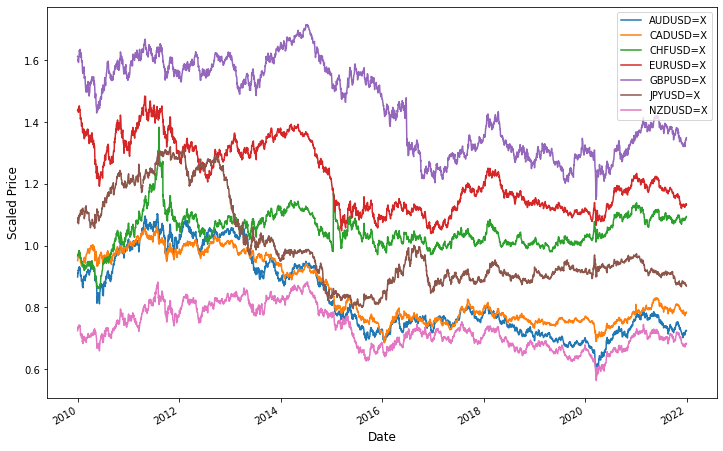

In [4]:
df_orig=yf.download(SYMBOLS, START_DATE, END_DATE)['Close']
df=df_orig
df['JPYUSD=X']=df_orig['JPYUSD=X']*100   

#df.rename(columns={"AUDUSD=X":"AUDUSD",  "GBPUSD=X":"GBPUSD", "CADUSD=X":"CADUSD", "CHFUSD=X":"CHFUSD", \
#                   "EURUSD=X":"EURUSD", "JPYUSD=X":"JPYUSD", "NZDUSD=X":"NZDUSD"}, inplace=True)

df.plot()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Scaled Price', fontsize=12)
plt.legend(prop={'size': 10})
plt.show()


In [5]:
df.rename(columns={'CADUSD=X': 'label'}, inplace=True)

In [6]:
df.head(2)

,AUDUSD=X,label,CHFUSD=X,EURUSD=X,GBPUSD=X,JPYUSD=X,NZDUSD=X
Date,,,,,,,
2010-01-01,0.898473,0.951294,0.967211,1.438994,1.613294,1.076195,0.724480
2010-01-04,0.912492,0.960615,0.971723,1.442398,1.611370,1.081140,0.734214


In [7]:
df = df[~df['label'].isnull()].copy()
df.head(2)

,AUDUSD=X,label,CHFUSD=X,EURUSD=X,GBPUSD=X,JPYUSD=X,NZDUSD=X
Date,,,,,,,
2010-01-01,0.898473,0.951294,0.967211,1.438994,1.613294,1.076195,0.724480
2010-01-04,0.912492,0.960615,0.971723,1.442398,1.611370,1.081140,0.734214


## b. Use the 2010-2020 data for training

### Train/Test Split and Modeling

In [8]:
train = df[df.index<'2021-01-01'].copy()
test = df[df.index>='2021-01-01'].copy()
print(train.shape, test.shape)

(2864, 7) (261, 7)


In [9]:
X_train, y_train = train.drop(labels='label', axis=1), train.label
print(X_train.shape, y_train.shape)

(2864, 6) (2864,)


In [10]:
pipe = Pipeline(steps=[('s', MinMaxScaler(feature_range=(0,1))),
                          ('xgb', xg.XGBRegressor(objective ='reg:squarederror', seed=123))],
                   verbose=True)
param_grid = {
    'xgb__max_depth': [1,2,3],
    'xgb__n_estimators': [80, 100, 500],
    'xgb__learning_rate': [0.05, 0.1, 0.2]
}
search = model_selection.GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring = 'neg_mean_squared_error', error_score="raise", return_train_score=True, verbose=2)
search = search.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[Pipeline] ................. (step 1 of 2) Processing s, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=   1.1s


In [11]:
search.best_params_

{'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 500}

In [12]:
score = search.cv_results_['mean_test_score'].max()
print(score)

-0.0004857207370638116


In [13]:
# inference
y_pred = search.predict(test.drop(labels='label', axis=1))
test['projected_price'] = y_pred

## c. Implement a trading strategy; Generate Trading Signals

In [14]:
test.loc[test.label - test.projected_price < -0.001, 'buy'] = 1
test.loc[test.label - test.projected_price > 0.02, 'sell'] = 1
test.head(5)

,AUDUSD=X,label,CHFUSD=X,EURUSD=X,GBPUSD=X,JPYUSD=X,NZDUSD=X,projected_price,buy,sell
Date,,,,,,,,,,
2021-01-01,0.770297,0.809723,1.113462,1.218027,1.367301,0.968748,0.718200,0.781591,NaN,1.0
2021-01-04,0.771230,0.786034,1.132375,1.225070,1.368420,0.968626,0.719839,0.775417,NaN,NaN
2021-01-05,0.767100,0.782411,1.134765,1.225160,1.357160,0.969697,0.717829,0.777103,NaN,NaN
2021-01-06,0.776600,0.788973,1.138719,1.230027,1.362955,0.973918,0.725689,0.784054,NaN,NaN
2021-01-07,0.781700,0.789553,1.138861,1.234111,1.362528,0.970648,0.730578,0.785617,NaN,NaN


In [15]:
test.buy.value_counts()

1.0    14
Name: buy, dtype: int64

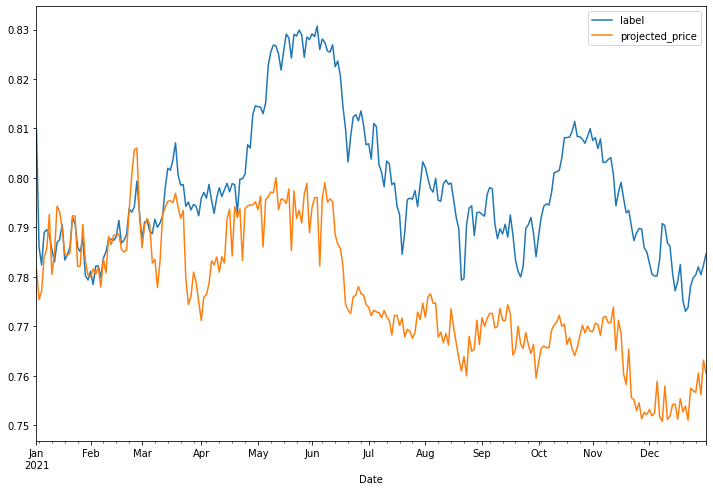

In [16]:
test[['label', 'projected_price']].plot()

In [18]:
test.loc[test.buy==1, 'action'] = 1
test.loc[test.sell==1, 'action'] = -1
test.loc[test.action.isnull(), 'action'] = 0
test.head(3)

,AUDUSD=X,label,CHFUSD=X,EURUSD=X,GBPUSD=X,JPYUSD=X,NZDUSD=X,projected_price,buy,sell,action
Date,,,,,,,,,,,
2021-01-01,0.770297,0.809723,1.113462,1.218027,1.367301,0.968748,0.718200,0.781591,NaN,1.0,-1.0
2021-01-04,0.771230,0.786034,1.132375,1.225070,1.368420,0.968626,0.719839,0.775417,NaN,NaN,0.0
2021-01-05,0.767100,0.782411,1.134765,1.225160,1.357160,0.969697,0.717829,0.777103,NaN,NaN,0.0


In [19]:
test['Trade'] = test.action - test.action.shift(1)
test.at['2021-01-01', 'Trade'] = test.loc['2021-01-01', 'action']

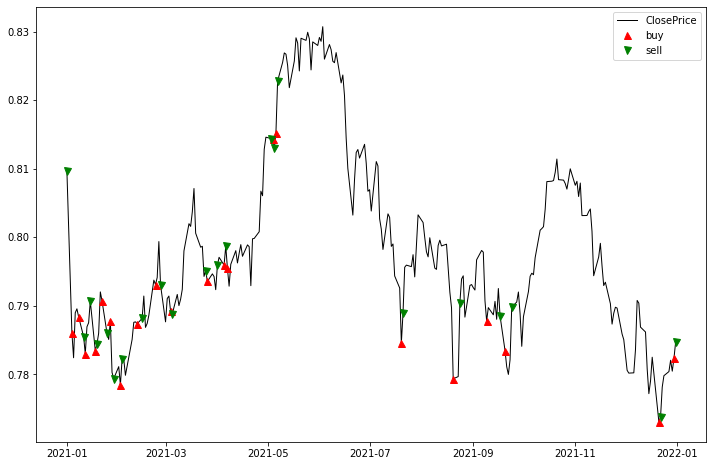

In [20]:
# Visualize trading signals
plt.plot(test.index, test.label, color='k', lw=1., label='ClosePrice')
plt.plot(test.loc[test.Trade == 1].index, test.label[test.Trade == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(test.loc[test.Trade == -1].index, test.label[test.Trade == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

### Calculate Holdings, Cash Position, Total Equity, and PnL

In [21]:
NUM_SHARES_PER_TRADE = 1000
INITIAL_CASH = 1000
test['pos'] = test.Trade * test.label * NUM_SHARES_PER_TRADE
test['holdings'] = test.action * NUM_SHARES_PER_TRADE * test.label
test['cash'] = INITIAL_CASH - test['pos'].cumsum()
test['total'] = test.cash + test.holdings
test['pnl'] = test['total']  - INITIAL_CASH
test.head(20)

,AUDUSD=X,label,CHFUSD=X,EURUSD=X,GBPUSD=X,JPYUSD=X,NZDUSD=X,projected_price,buy,sell,action,Trade,pos,holdings,cash,total,pnl
Date,,,,,,,,,,,,,,,,,
2021-01-01,0.770297,0.809723,1.113462,1.218027,1.367301,0.968748,0.718200,0.781591,NaN,1.0,-1.0,-1.0,-809.723139,-809.723139,1809.723139,1000.000000,0.000000
2021-01-04,0.771230,0.786034,1.132375,1.225070,1.368420,0.968626,0.719839,0.775417,NaN,NaN,0.0,1.0,786.033750,0.000000,1023.689389,1023.689389,23.689389
2021-01-05,0.767100,0.782411,1.134765,1.225160,1.357160,0.969697,0.717829,0.777103,NaN,NaN,0.0,0.0,0.000000,0.000000,1023.689389,1023.689389,23.689389
2021-01-06,0.776600,0.788973,1.138719,1.230027,1.362955,0.973918,0.725689,0.784054,NaN,NaN,0.0,0.0,0.000000,0.000000,1023.689389,1023.689389,23.689389
2021-01-07,0.781700,0.789553,1.138861,1.234111,1.362528,0.970648,0.730578,0.785617,NaN,NaN,0.0,0.0,0.000000,0.000000,1023.689389,1023.689389,23.689389
2021-01-08,0.776900,0.788407,1.129752,1.227144,1.356963,0.963484,0.726549,0.792597,1.0,NaN,1.0,1.0,788.407207,788.407207,235.282183,1023.689389,23.689389
2021-01-11,0.771653,0.785497,1.126583,1.218621,1.351625,0.960698,0.719932,0.780457,NaN,NaN,0.0,-1.0,-785.496593,0.000000,1020.778775,1020.778775,20.778775
2021-01-12,0.770750,0.783000,1.124075,1.216070,1.352411,0.960356,0.717401,0.784846,1.0,NaN,1.0,1.0,782.999516,782.999516,237.779260,1020.778775,20.778775
2021-01-13,0.777605,0.786924,1.128796,1.220889,1.367054,0.963837,0.722930,0.794291,1.0,NaN,1.0,0.0,0.000000,786.924481,237.779260,1024.703741,24.703741


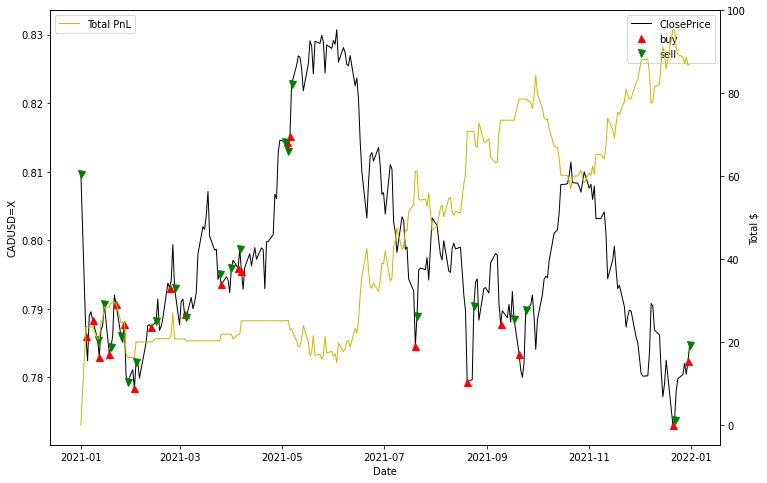

In [22]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(test.index, test.label, color='k', lw=1., label='ClosePrice')
ax2.plot(test.index, test.pnl, color='y', lw=1, label='Total PnL')
ax1.plot(test.loc[test.Trade == 1].index, test.label[test.Trade == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
ax1.plot(test.loc[test.Trade == -1].index, test.label[test.Trade == -1], color='g', lw=0, marker='v', markersize=7, label='sell')

ax1.set_xlabel('Date')
ax1.set_ylabel('CADUSD=X', color='k')
ax2.set_ylabel('Total $', color='k')

ax1.legend()
ax2.legend()
plt.show()

In [23]:
# Final PnL
print(f"Initial investment: ${INITIAL_CASH}\nFinal PnL: ${round(test.pnl.values[-1],2)}")

Initial investment: $1000
Final PnL: $86.82


# Question 3 (Bonus) Deep Learning Approach

In [24]:
import keras
from keras.utils import np_utils
import itertools
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
df_deep=yf.download(SYMBOLS, START_DATE, END_DATE)

[*********************100%***********************]  7 of 7 completed


In [26]:
# Deal with Open, Close, High, Low.  Volume data not available
df_deep.drop(columns=['Adj Close', 'Volume'], level=0, inplace=True)
df_deep.sort_values('Date', inplace=True)

In [27]:
# DoD Returns
df_deep['Open'] = df_deep['Open'].pct_change()
df_deep['High'] = df_deep['High'].pct_change()
df_deep['Low'] = df_deep['Low'].pct_change()
df_deep['Close'] = df_deep['Close'].pct_change()

In [28]:
# Drop anything with NaN
df_deep.dropna(how='any', axis=0, inplace=True)
df_deep.head()

Close                                                    \
            AUDUSD=X  CADUSD=X  CHFUSD=X  EURUSD=X  GBPUSD=X  JPYUSD=X   
Date                                                                     
2010-01-04  0.015604  0.009798  0.004664  0.002366 -0.001192  0.004595   
2010-01-05 -0.000729  0.001443 -0.004450 -0.004022 -0.007628  0.009936   
2010-01-06  0.009481  0.007365  0.005936  0.002650  0.002067 -0.008348   
2010-01-07 -0.002937 -0.002031 -0.005805 -0.005971 -0.005609 -0.011072   
2010-01-08  0.007956  0.004078  0.009769  0.006499  0.005657  0.007878   

                          High                      ...       Low            \
            NZDUSD=X  AUDUSD=X  CADUSD=X  CHFUSD=X  ...  GBPUSD=X  JPYUSD=X   
Date                                                ...                       
2010-01-04  0.013436  0.017182  0.015260  0.007013  ... -0.004097 -0.001191   
2010-01-05 -0.000587  0.003761  0.001742  0.001561  ... -0.005909  0.007731   
2010-01-06  0.005756  0.004978  0.002230  0.000098  ... -0.001642 -0.002416   
2010-01-07 -0.007181  0.004631  0.002235  0.000781  ... -0.002703 -0.010935   
2010-01-08  0.005970 -0.000833 -0.000583  0.002349  ...  0.001082  0.000801   

                          Open                                          \
            NZDUSD=X  AUDUSD=X  CADUSD=X  CHFUSD=X  EURUSD=X  GBPUSD=X   
Date                                                                     
2010-01-04 -0.006192 -0.000987  0.004010 -0.001737 -0.001188 -0.002776   
2010-01-05  0.017062  0.017161  0.006534  0.006901  0.008180 -0.001144   
2010-01-06 -0.001973 -0.001094  0.001443 -0.004451 -0.004238 -0.007757   
2010-01-07  0.000805  0.009295  0.007465  0.005839  0.002578  0.001778   
2010-01-08 -0.002917 -0.002479 -0.002225 -0.005709 -0.005700 -0.005244   

                                
            JPYUSD=X  NZDUSD=X  
Date                            
2010-01-04  0.001941 -0.003763  
2010-01-05  0.003136  0.015355  
2010-01-06  0.010049 -0.001248  
2010-01-07 -0.008512  0.006054  
2010-01-08 -0.011805 -0.007328  

[5 rows x 28 columns]

In [29]:
# Normalize values (TBD)
#df_deep.shape

In [30]:
# Separate out target/label
label = df_deep['Close']['CADUSD=X']
df_deep.drop(columns=['CADUSD=X'], level=1, inplace=True)

# Train/test split
deep_train = df_deep[df_deep.index<'2021-01-01'].copy()
deep_test = df_deep[df_deep.index>='2021-01-01'].copy()

y_train = label[label.index<'2021-01-01'].copy()
y_test = label[label.index>='2021-01-01'].copy()

print(deep_train.shape, deep_test.shape)
print(y_train.shape, y_test.shape)

(2865, 24) (261, 24)
(2865,) (261,)


In [32]:
def data_transform(X, y, numcolumns, look_back=30):
  temp = np.zeros(shape=(X.shape[0]-look_back, look_back, X.shape[1]))
  temp2 = []

  # Loop over 30 day periods and columns
  for j in range(numcolumns):
    for i in range (0, X.shape[0]-look_back):
      temp[i,:,j] = X.iloc[i:i + look_back, j].values
      #print(X.iloc[i:i + look_back, j].values)
  
  # Handle y (label) now
  for i in range (0, X.shape[0]-look_back):
    temp2.append(y.iloc[i + look_back])
  temp2 = np.array(temp2)
  temp2=np.reshape(temp2,(len(temp2),-1))

  # Debug check on shapes
  print(temp.shape, temp2.shape)
  return temp, temp2

deep_X_train, deep_y_train = data_transform(deep_train, y_train, numcolumns=deep_train.shape[1])
deep_X_test, deep_y_test = data_transform(deep_test, y_test, numcolumns=deep_test.shape[1])

(2835, 30, 24) (2835, 1)
(231, 30, 24) (231, 1)


In [33]:
X_train_LSTM, Y_train_LSTM = deep_X_train, deep_y_train
X_test_LSTM, Y_test_LSTM = deep_X_test, deep_y_test

In [34]:
dot_img_file = '/tmp/model_1.png'

# Select configuration of model:
# 0 - original, simple 50 neuron LSTM input later and single neuron Dense output
# 1 - LSTM(100) and dropout 20%, LSTM(50) and dropout 10%
configuration = 1

# design network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    if configuration == 0:
      model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
      model.add(Dense(1))

    if configuration == 1:
      model.add(LSTM(100, return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
      model.add(Dropout(0.2))
      model.add(LSTM(50))
      model.add(Dropout(0.1))
      model.add(Dense(1))

    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_activations=True)
    model.summary()
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM,\
                              Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),\
                              epochs=50, batch_size=72, verbose=0, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           50000     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


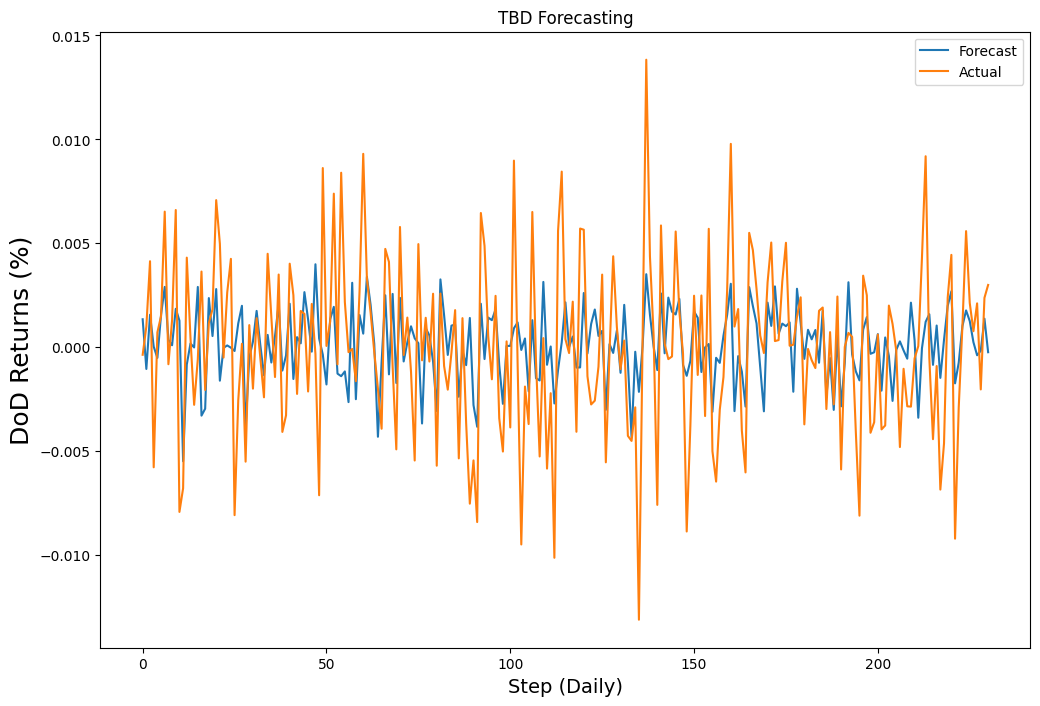

In [35]:
# Perform inference
predictions = LSTMModel.predict(X_test_LSTM)

# Visualize
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.title('TBD Forecasting')
plt.xlabel('Step (Daily)', fontsize=14)
plt.ylabel('DoD Returns (%)', fontsize=18)
plt.plot(predictions)
#plt.plot(scaler4.inverse_transform(Y_test_LSTM))
plt.plot(Y_test_LSTM)
plt.legend(['Forecast', 'Actual'])
plt.show()

In [36]:
df_final = deep_test.copy()
df_final['Predicted_Returns'] = np.pad(predictions, [(30, 0), (0, 0)], mode='constant', constant_values=0)
df_final['Actual_Returns'] = y_test

df_final.loc[df_final.Predicted_Returns > 0.002, 'sell'] = 1
df_final.loc[df_final.Predicted_Returns < -0.001, 'buy'] = 1

print(f'Buy signals: {df_final.buy.value_counts()}\nSell signals: {df_final.sell.value_counts()}')

Buy signals: 1.0    52
Name: buy, dtype: int64
Sell signals: 1.0    32
Name: sell, dtype: int64


In [37]:
df_final.loc[df_final.buy==1, 'action'] = 1
df_final.loc[df_final.sell==1, 'action'] = -1
df_final.loc[df_final.action.isnull(), 'action'] = 0
df_final.tail(10)

Close                                                    \
            AUDUSD=X  CHFUSD=X  EURUSD=X  GBPUSD=X  JPYUSD=X  NZDUSD=X   
Date                                                                     
2021-12-20 -0.008170 -0.004820 -0.007994 -0.007078  0.001277 -0.009518   
2021-12-21 -0.001051  0.001703  0.003022 -0.001469 -0.001267 -0.002746   
2021-12-22  0.005387 -0.001408  0.000892  0.004514 -0.002913  0.007876   
2021-12-23  0.009261  0.003894  0.003659  0.006209 -0.001113  0.005887   
2021-12-24  0.002662  0.000914 -0.000136  0.004089 -0.002944  0.002408   
2021-12-27 -0.000265 -0.000197 -0.000272 -0.000173  0.001093 -0.001029   
2021-12-28  0.000790  0.001767  0.000510  0.002862 -0.003998  0.000412   
2021-12-29 -0.000415  0.000284 -0.001346 -0.000698  0.000165 -0.001818   
2021-12-30  0.003427  0.003612  0.004010  0.004877 -0.001522  0.005012   
2021-12-31 -0.001238 -0.000109 -0.003092 -0.000031 -0.000999 -0.001359   

                High                                ...      Open            \
            AUDUSD=X  CHFUSD=X  EURUSD=X  GBPUSD=X  ...  CHFUSD=X  EURUSD=X   
Date                                                ...                       
2021-12-20 -0.007641 -0.002067 -0.003923 -0.007271  ... -0.004765 -0.008196   
2021-12-21  0.001836 -0.000218 -0.000113  0.001339  ...  0.001834  0.003045   
2021-12-22  0.010486 -0.000218  0.003426  0.007630  ... -0.001538  0.001219   
2021-12-23  0.003867  0.001743  0.000317  0.005603  ...  0.004046  0.003512   
2021-12-24  0.000428  0.001320 -0.000113 -0.000859  ...  0.000762 -0.000487   
2021-12-27 -0.000566 -0.000338 -0.000820  0.001117  ... -0.000081 -0.000068   
2021-12-28  0.002900  0.001419  0.000088  0.001628  ...  0.001946  0.000521   
2021-12-29  0.001136  0.003451  0.002999  0.002727  ...  0.000098 -0.001448   
2021-12-30  0.000734 -0.000383 -0.000901  0.001650  ...  0.003283  0.004101   
2021-12-31 -0.000357  0.002779  0.001707  0.001992  ...  0.000000 -0.003216   

                                         Predicted_Returns Actual_Returns  \
            GBPUSD=X  JPYUSD=X  NZDUSD=X                                    
Date                                                                        
2021-12-20 -0.007078  0.001136 -0.009500         -0.001737      -0.009210   
2021-12-21 -0.001519 -0.000950 -0.002967         -0.000744      -0.002899   
2021-12-22  0.004552 -0.003122  0.007910          0.001013       0.001006   
2021-12-23  0.006182 -0.000955  0.005791          0.001772       0.005587   
2021-12-24  0.004277 -0.002909  0.001527          0.001260       0.002129   
2021-12-27 -0.000294  0.001041 -0.000116          0.000242       0.000773   
2021-12-28  0.002930 -0.003920  0.000116         -0.000385       0.002112   
2021-12-29 -0.000779  0.000183 -0.001463         -0.000166      -0.002029   
2021-12-30  0.004738 -0.001653  0.005048          0.001374       0.002378   
2021-12-31  0.000095 -0.000886 -0.001387         -0.000239       0.002997   

           sell  buy action  
                             
Date                         
2021-12-20  NaN  1.0    1.0  
2021-12-21  NaN  NaN    0.0  
2021-12-22  NaN  NaN    0.0  
2021-12-23  NaN  NaN    0.0  
2021-12-24  NaN  NaN    0.0  
2021-12-27  NaN  NaN    0.0  
2021-12-28  NaN  NaN    0.0  
2021-12-29  NaN  NaN    0.0  
2021-12-30  NaN  NaN    0.0  
2021-12-31  NaN  NaN    0.0  

[10 rows x 29 columns]

In [38]:
df_final['Trade'] = df_final.action - df_final.action.shift(1)
df_final.at['2021-01-01', 'Trade'] = df_final.loc['2021-01-01', 'action']

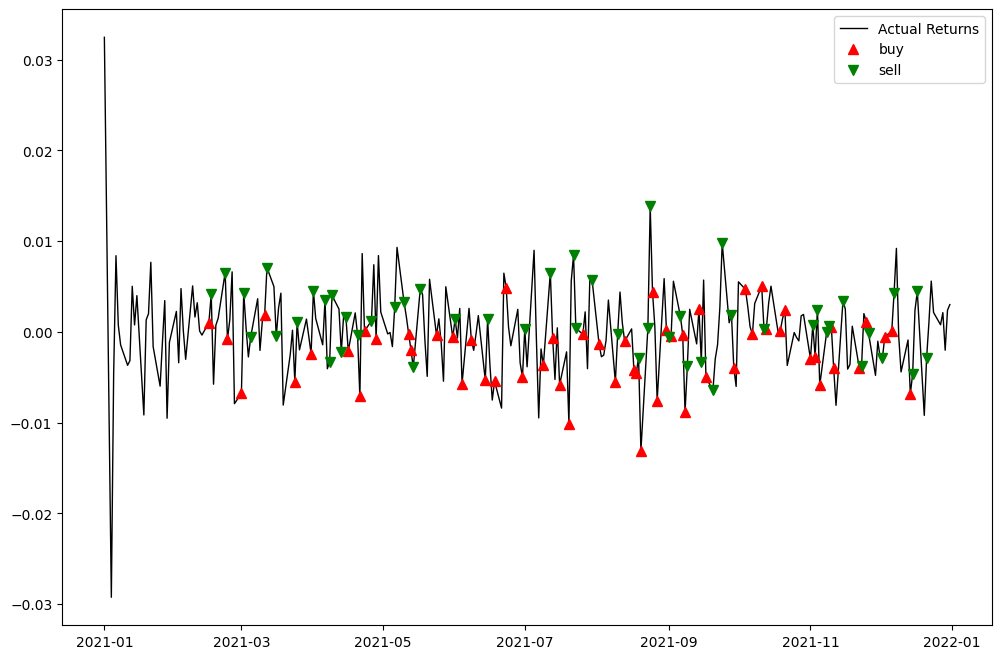

In [39]:
# Visualize trading signals
plt.figure(figsize=(12,8))
plt.plot(df_final.index, df_final.Actual_Returns, color='k', lw=1., label='Actual Returns')
plt.plot(df_final.loc[df_final.Trade == 1].index, df_final.Actual_Returns[df_final.Trade == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df_final.loc[df_final.Trade == -1].index, df_final.Actual_Returns[df_final.Trade == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

In [40]:
NUM_SHARES_PER_TRADE = 1000
INITIAL_CASH = 1000
df_final['pos'] = df_final.Trade * df_final.Actual_Returns * NUM_SHARES_PER_TRADE
df_final['holdings'] = df_final.action * NUM_SHARES_PER_TRADE * df_final.Actual_Returns
df_final['cash'] = INITIAL_CASH - df_final['pos'].cumsum()
df_final['total'] = df_final.cash + df_final.holdings
df_final['pnl'] = df_final['total']  - INITIAL_CASH
df_final.head(20)

Close                                                    \
            AUDUSD=X  CHFUSD=X  EURUSD=X  GBPUSD=X  JPYUSD=X  NZDUSD=X   
Date                                                                     
2021-01-01  0.001779 -0.018394 -0.009726  0.003107 -0.001017 -0.004629   
2021-01-04  0.001211  0.016986  0.005782  0.000818 -0.000126  0.002282   
2021-01-05 -0.005355  0.002111  0.000074 -0.008228  0.001105 -0.002792   
2021-01-06  0.012384  0.003484  0.003973  0.004270  0.004353  0.010951   
2021-01-07  0.006567  0.000125  0.003320 -0.000313 -0.003358  0.006736   
2021-01-08 -0.006141 -0.007999 -0.005645 -0.004084 -0.007380 -0.005514   
2021-01-11 -0.006754 -0.002805 -0.006946 -0.003933 -0.002892 -0.009107   
2021-01-12 -0.001170 -0.002226 -0.002093  0.000582 -0.000355 -0.003515   
2021-01-13  0.008894  0.004199  0.003963  0.010827  0.003624  0.007706   
2021-01-14 -0.003719 -0.001127 -0.003801 -0.001556 -0.000819 -0.005393   
2021-01-15  0.003700 -0.001520 -0.000923  0.002518  0.000087  0.003811   
2021-01-18 -0.011179 -0.004405 -0.006843 -0.007915 -0.000770 -0.013191   
2021-01-19 -0.000246  0.001437  0.000761  0.000435  0.001977 -0.000939   
2021-01-20  0.003228  0.003266  0.005098  0.004639 -0.001867  0.001825   
2021-01-21  0.005693 -0.001439 -0.001914  0.001777  0.003303  0.008077   
2021-01-22  0.000686  0.004428  0.004182  0.004462  0.000473  0.004121   
2021-01-25 -0.005827  0.000042  0.000259 -0.003006 -0.002611 -0.004476   
2021-01-26  0.000414 -0.003037 -0.001907 -0.000673  0.000164  0.002255   
2021-01-27  0.004423  0.001489  0.001379  0.004573  0.001516  0.005139   
2021-01-28 -0.013174 -0.002475 -0.004762 -0.005249 -0.005185 -0.013016   

                High                                ... Actual_Returns sell  \
            AUDUSD=X  CHFUSD=X  EURUSD=X  GBPUSD=X  ...                       
Date                                                ...                       
2021-01-01  0.060222 -0.011478 -0.007516  0.000397  ...       0.032454  NaN   
2021-01-04 -0.056728  0.012786  0.007612  0.001007  ...      -0.029256  NaN   
2021-01-05  0.001421  0.000319 -0.001232 -0.005689  ...      -0.004608  NaN   
2021-01-06  0.008691  0.003164  0.004508  0.003226  ...       0.008387  NaN   
2021-01-07 -0.000637 -0.002268 -0.000370 -0.002631  ...       0.000734  NaN   
2021-01-08 -0.002099 -0.005598 -0.005146 -0.000150  ...      -0.001451  NaN   
2021-01-11 -0.008793 -0.004973 -0.006722 -0.007482  ...      -0.003692  NaN   
2021-01-12  0.001316 -0.002430 -0.001729  0.007827  ...      -0.003179  NaN   
2021-01-13  0.005440  0.004463  0.003814  0.004713  ...       0.005013  NaN   
2021-01-14  0.001336 -0.001523 -0.004261 -0.000493  ...       0.000756  NaN   
2021-01-15 -0.000552 -0.000451 -0.000851  0.000342  ...       0.003985  NaN   
2021-01-18 -0.011042 -0.003316 -0.006273 -0.007882  ...      -0.009166  NaN   
2021-01-19  0.002753  0.004006  0.004858  0.002794  ...       0.001310  NaN   
2021-01-20  0.005049 -0.000485  0.001243  0.006364  ...       0.001989  NaN   
2021-01-21  0.002705  0.002068  0.000983  0.002240  ...       0.007659  NaN   
2021-01-22 -0.001952  0.001075  0.001318 -0.000577  ...      -0.001637  NaN   
2021-01-25 -0.002678 -0.000904 -0.000165 -0.001057  ...      -0.005989  NaN   
2021-01-26  0.000813 -0.002267 -0.000902  0.001553  ...      -0.001146  NaN   
2021-01-27  0.000864  0.000858 -0.000298  0.001142  ...       0.003435  NaN   
2021-01-28 -0.010771 -0.001240 -0.002249 -0.001977  ...      -0.009527  NaN   

           buy action Trade  pos holdings    cash   total  pnl  
                                                                
Date                                                            
2021-01-01 NaN    0.0   NaN  NaN      0.0     NaN     NaN  NaN  
2021-01-04 NaN    0.0   0.0 -0.0     -0.0  1000.0  1000.0  0.0  
2021-01-05 NaN    0.0   0.0 -0.0     -0.0  1000.0  1000.0  0.0  
2021-01-06 NaN    0.0   0.0  0.0      0.0  1000.0  1000.0  0.0  
2021-01-07 NaN    0.0   0.0  0.0      0

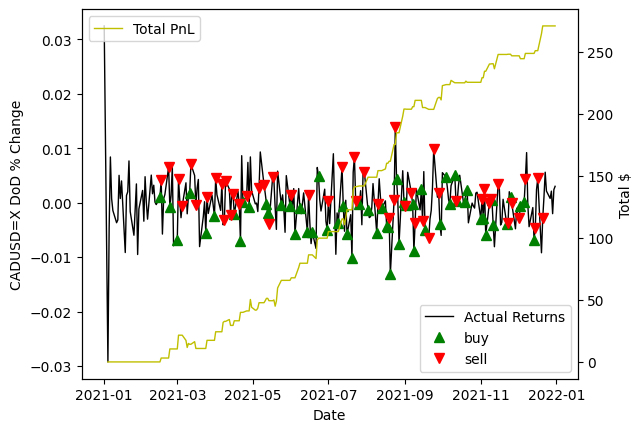

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_final.index, df_final.Actual_Returns, color='k', lw=1., label='Actual Returns')
ax2.plot(df_final.index, df_final.pnl, color='y', lw=1, label='Total PnL')
ax1.plot(df_final.loc[df_final.Trade == 1].index, df_final.Actual_Returns[df_final.Trade == 1], color='g', lw=0, marker='^', markersize=7, label='buy')
ax1.plot(df_final.loc[df_final.Trade == -1].index, df_final.Actual_Returns[df_final.Trade == -1], color='r', lw=0, marker='v', markersize=7, label='sell')

ax1.set_xlabel('Date')
ax1.set_ylabel('CADUSD=X DoD % Change', color='k')
ax2.set_ylabel('Total $', color='k')

ax1.legend(loc='lower right')
ax2.legend(loc='best')
#prop={'size': 10}
plt.show()

In [42]:
# Final PnL
print(f"Initial investment: ${INITIAL_CASH}\nFinal PnL: ${round(df_final.pnl.values[-1],2)}")

Initial investment: $1000
Final PnL: $271.14
